# LSTM. Трансформер. Механизм внимания (ноутбук)

> Завершим тему рекуррентных нейронных сетей. Начнем знакомство с архитектурой нейронных сетей Трансформер.

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

## Данные

In [2]:
aneks = []

with open('anek.txt', 'r', encoding='utf-8') as f:
    aneks.extend(f.read().split('\n'))

In [3]:
aneks[0]

'Штирлиц спросил Кэт   Вы любите фильмы про любовь?   Бесспорно!  ответила Кэт.   А я с порно,  признался Штирлиц.'

In [4]:
vocabulary = ['_', '#', '<']  # sos, eos, pad
vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper())
vocabulary.extend('0123456789 ,.!?-')

In [5]:
_idx2char = {i: char for i, char in enumerate(vocabulary)}
_char2idx = {char: i for i, char in enumerate(vocabulary)}

In [6]:
_idx2char[2]

'<'

In [7]:
class Vocabulary:
    def __init__(self):
        self.vocabulary = ['_', '#', '<']  # sos, eos, pad
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper())
        self.vocabulary.extend('0123456789 ,.!?-')

        self._idx2char = {i: char for i, char in enumerate(self.vocabulary)}
        self._char2idx = {char: i for i, char in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2char(self, idx: int):
        if idx not in self._idx2char:
            return '<'

        return self._idx2char[idx]#вернет символ по индексу

    def char2idx(self, char: str):
        if char not in self._char2idx:
            return self.get_pad()

        return self._char2idx[char]

    def encode(self, text):
        result = [self.char2idx(char) for char in text]

        result = [self.get_sos()] + result + [self.get_eos()]

        return result

    def get_sos(self):
        return self.char2idx('_')

    def get_eos(self):
        return self.char2idx('#')

    def get_pad(self):
        return self.char2idx('<')

In [8]:
from torch.utils.data import Dataset


class Anekdotes(Dataset):
    def __init__(self, aneks):
        self.aneks = aneks

        self.vocab = Vocabulary()

    def __getitem__(self, idx):
        return torch.LongTensor(self.vocab.encode(self.aneks[idx])) # кодирует каждый символ в предложение + sos + end

    def __len__(self):
        return len(self.aneks)

In [9]:
dataset = Anekdotes(aneks)

In [10]:
dataset[10], len(dataset[10])

(tensor([ 0, 61, 22, 12, 20, 15, 12, 26, 79, 22, 18, 19, 12, 15, 79,  4, 23, 20,
         10, 23, 13, 14, 23, 81, 79, 55, 18, 15, 32, 14, 18, 79, 27,  8, 20,  8,
         11, 79,  7,  5,  3, 79, 27,  3, 21,  3, 79,  8, 16, 23, 79, 23,  7,  3,
         15, 18, 21, 32, 79,  8,  8, 79, 23, 22, 18, 19, 12, 22, 32, 81,  1]),
 71)

In [11]:
aneks[10], len(aneks[10])

('Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.', 69)

In [12]:
from torch.utils.data import random_split


train_dataset, valid_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [13]:
>>> from torch.nn.utils.rnn import pad_sequence
>>> a = torch.ones(25, 300)
>>> b = torch.ones(22, 300)
>>> c = torch.ones(15, 300)
>>> pad_sequence([a, b, c], batch_first=True).size()

torch.Size([3, 25, 300])

In [14]:
from torch.nn.utils.rnn import pad_sequence


pad_idx = dataset.vocab.get_pad()

# ограничим до 256 наши батчи
def collate_fn(batch):
    return pad_sequence([b[:256] for b in batch], padding_value=pad_idx, batch_first=True)

In [15]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NCCL_P2P_DISABLE"] = "1"
#!#OMP_NUM_THREADS=1 MKL_NUM_THREADS=1 python Lecture_9_Intro_to_DL.ipynb

In [16]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)

## Модель

### [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

$$h_t = \tanh\left( x_tW_{xh}^T + b_{xh} + h_{t-1}W_{hh}^T + b_{hh} \right)$$

либо если `bias=False`, то

$$h_t = \tanh\left( x_tW_{xh}^T + h_{t-1}W_{hh}^T \right)$$

Параметры:

 - `input_size` - размерность $x_i$
 - `hidden_size` - размерность $h_i$
 - `num_layers` - количество слоев (по умолчанию 1)
 - `dropout` - какой делать дропаут при количестве слоев > 1 (по умолчанию 0)
 - `bidirectional` - двунаправленная

In [17]:
layer = nn.RNN(input_size=3, hidden_size=6)

In [18]:
layer

RNN(3, 6)

In [19]:
print(layer.weight_hh_l0)
print()
print(layer.weight_hh_l0.shape)# 6 - это hidden size

Parameter containing:
tensor([[ 0.2082,  0.0623,  0.3377,  0.2185,  0.1692,  0.2289],
        [ 0.0612,  0.3933,  0.3653,  0.2516,  0.3007, -0.0733],
        [ 0.2787,  0.3451, -0.2461, -0.1946, -0.1107, -0.2474],
        [ 0.1061,  0.2022, -0.0181, -0.1144, -0.3573,  0.1615],
        [-0.0236,  0.1253, -0.2283, -0.0060, -0.2845, -0.1892],
        [-0.2363, -0.2065, -0.2191,  0.0771,  0.2829,  0.3248]],
       requires_grad=True)

torch.Size([6, 6])


In [20]:
print(layer.weight_ih_l0)
print()
print(layer.weight_ih_l0.shape)

Parameter containing:
tensor([[-0.1109,  0.1428, -0.2539],
        [ 0.1773,  0.1756, -0.1143],
        [-0.2971, -0.3019, -0.2985],
        [ 0.1884,  0.3133, -0.2301],
        [-0.2320,  0.0090, -0.3485],
        [ 0.4030,  0.2660,  0.3265]], requires_grad=True)

torch.Size([6, 3])


In [21]:
print(layer.bias_hh_l0)
print()
print(layer.bias_hh_l0.shape)

Parameter containing:
tensor([-0.3354,  0.1982, -0.1896, -0.0691,  0.0295,  0.0351],
       requires_grad=True)

torch.Size([6])


In [22]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([-0.1381, -0.1713,  0.2938, -0.1809, -0.0665, -0.1349],
       requires_grad=True)

torch.Size([6])


In [23]:
torch.randn(2, 2, 4)

tensor([[[ 0.6021,  0.2853,  0.8773, -0.0670],
         [ 0.3562, -1.2406,  1.2455, -0.1335]],

        [[-0.2112, -0.3011,  0.1900, -0.4704],
         [ 1.0474, -1.4184, -1.2866,  0.6040]]])

In [24]:
batch_size = 5 # колво бачей
seq_len = 7 # длинна последовательности
input_dim = 3 # длинна каждого вектора в последовательности 

layer = nn.RNN(input_size=3, hidden_size=6, batch_first=True)

x = torch.randn(batch_size, seq_len, input_dim)

hs, h_last = layer(x)

#print(hs)
print()
print(hs.shape)

print()

#print(h_last)
print()
print(h_last.shape)


torch.Size([5, 7, 6])


torch.Size([1, 5, 6])


In [25]:
batch_size = 5 
seq_len = 7 
input_dim = 3 # длина эмбединга

layer = nn.RNN(input_size=3, hidden_size=6, batch_first=False)

x = torch.randn(batch_size, seq_len, input_dim)

hs, h_last = layer(x) # hs - набор всех скрытых состояний (все h_t)
# h_last последнее скрытое состояние

print(hs)
print()
print(hs.shape)

print()

print(h_last)
print()
print(h_last.shape)

tensor([[[-0.3047, -0.6532,  0.3502, -0.0885, -0.6394, -0.0770],
         [-0.2575, -0.5989,  0.0995, -0.1215, -0.4351,  0.0942],
         [-0.6702, -0.5352,  0.6095, -0.6134, -0.2731,  0.4784],
         [-0.1334, -0.5980,  0.0614,  0.0324, -0.4654,  0.0345],
         [-0.1797, -0.5885, -0.0066, -0.0498, -0.3973,  0.0924],
         [-0.7833,  0.2210,  0.0682, -0.9066,  0.9582,  0.9817],
         [-0.1445, -0.4587, -0.1065, -0.1005,  0.0036,  0.4160]],

        [[-0.9062,  0.0810,  0.0017, -0.9693,  0.9020,  0.9355],
         [-0.6998, -0.3205,  0.0133, -0.7702,  0.2315,  0.6191],
         [ 0.2738, -0.7283, -0.1533,  0.6905, -0.7519, -0.4820],
         [-0.4365, -0.2064, -0.2047, -0.6040,  0.2400,  0.5492],
         [ 0.0476, -0.5462, -0.4137,  0.1272, -0.6011, -0.3009],
         [-0.7929, -0.7443,  0.6732, -0.3168, -0.0897,  0.8973],
         [-0.3789, -0.6740,  0.3570, -0.1027, -0.8709, -0.2385]],

        [[-0.8648, -0.7171,  0.8700, -0.4559, -0.0717,  0.9316],
         [-0.6653, -0

### [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

$$r_t = \sigma\left( x_t W_{xr}^T + b_{xr} + h_{t-1}W_{hr}^T + b_{hr} \right)$$
$$z_t = \sigma\left( x_t W_{xz}^T + b_{xz} + h_{t-1}W_{hz}^T + b_{hz} \right)$$
$$\hat{h_t} = \tanh\left( x_tW_{xh}^T + b_{xh} + r_t * (h_{t-1}W_{hh}^T + b_{hh}) \right)$$
$$h_t = (1 - z_t) * \hat{h_t} + z_t * h_{t-1}$$

Параметры такие же как у RNN.

In [26]:
layer = nn.GRU(input_size=3, hidden_size=6)

In [27]:
print(layer.weight_hh_l0)
print()
print(layer.weight_hh_l0.shape)

Parameter containing:
tensor([[-0.3795,  0.3945,  0.1401, -0.0177, -0.1429,  0.0720],
        [ 0.2244,  0.2862,  0.1870,  0.2316, -0.1476, -0.0174],
        [-0.2054, -0.0026, -0.2239,  0.3861, -0.1652, -0.3187],
        [ 0.1348, -0.3763, -0.3904, -0.2734, -0.2574, -0.3767],
        [-0.3540,  0.2581,  0.0322,  0.1433, -0.3617, -0.0644],
        [-0.0868,  0.3581, -0.3808,  0.1610, -0.2713, -0.3582],
        [-0.1345,  0.1622, -0.3937,  0.2485, -0.3306, -0.3624],
        [ 0.2448,  0.3253,  0.1287, -0.1988, -0.1887,  0.2489],
        [-0.0123,  0.0712, -0.0278,  0.1780,  0.1249, -0.1700],
        [-0.0249,  0.1212,  0.2509,  0.0231, -0.0212,  0.3214],
        [ 0.1216, -0.1229, -0.2318,  0.2359,  0.1360,  0.1450],
        [ 0.3625,  0.0353,  0.3416,  0.0907,  0.0496, -0.3813],
        [-0.0670, -0.2634, -0.3678,  0.3101, -0.1298,  0.3099],
        [-0.1154, -0.3773,  0.1521, -0.0654,  0.1523,  0.3037],
        [ 0.0927,  0.2972, -0.0473, -0.1705, -0.2201,  0.2608],
        [-0.0736, 

In [28]:
print(layer.weight_ih_l0)
print()
print(layer.weight_ih_l0.shape)

Parameter containing:
tensor([[-0.1426,  0.2482,  0.2106],
        [-0.0789, -0.2776,  0.0064],
        [ 0.1400,  0.0772, -0.1338],
        [ 0.0165, -0.3468,  0.1825],
        [ 0.3825,  0.1400,  0.2545],
        [ 0.1456,  0.2762,  0.3746],
        [ 0.1200, -0.3751, -0.2630],
        [-0.2978,  0.3997, -0.3249],
        [ 0.2945, -0.0332,  0.1670],
        [ 0.3514,  0.3561, -0.1829],
        [ 0.2781,  0.1483, -0.0013],
        [ 0.3543, -0.0354,  0.1289],
        [-0.2710, -0.2487,  0.4025],
        [-0.3376,  0.3867, -0.2156],
        [ 0.1107,  0.3699,  0.1605],
        [-0.1742, -0.1445,  0.3100],
        [ 0.0776, -0.1434, -0.1630],
        [ 0.0675, -0.0098, -0.1735]], requires_grad=True)

torch.Size([18, 3])


In [29]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([-0.3949, -0.0474, -0.3430, -0.1024,  0.1599, -0.0782, -0.1384,  0.3510,
        -0.1596, -0.3429, -0.3584,  0.2238,  0.0414,  0.1248, -0.4007, -0.2065,
        -0.0577,  0.3954], requires_grad=True)

torch.Size([18])


In [30]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([-0.3949, -0.0474, -0.3430, -0.1024,  0.1599, -0.0782, -0.1384,  0.3510,
        -0.1596, -0.3429, -0.3584,  0.2238,  0.0414,  0.1248, -0.4007, -0.2065,
        -0.0577,  0.3954], requires_grad=True)

torch.Size([18])


### [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

Более страшные формулы, все в целом очень похоже на GRU. Параметры те же.

In [31]:
layer = nn.LSTM(input_size=3, hidden_size=6)

### Модель

In [32]:
class AnekdoteRNN(nn.Module):
    def __init__(self, num_tokens: int, emb_size: int=32, hidden_size: int=256):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, emb_size, padding_idx = pad_idx)
        # num_tokens = размер словаря - 85
        # emb_size = 32
        self.rnn = nn.LSTM(
            input_size=emb_size, #мы будем предсказывать вероятность следующего символа
            hidden_size=hidden_size,
            num_layers=4,
            dropout=0.3,
            batch_first=True
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_tokens)
        )

    def forward(self, x):
        x = self.embedding(x) 
        x, _ = self.rnn(x) # поскольку нам нужно для каждого токена предсказать какой следующий 
        # то мы нуждаемся во всех скрытый представлениях
        x  = self.output(x)

        return x

In [33]:
nn.Embedding(len(dataset.vocab.get_vocabulary()),32,padding_idx = pad_idx)(dataset[0]).shape

torch.Size([115, 32])

In [34]:
model = AnekdoteRNN(num_tokens=len(dataset.vocab.get_vocabulary()))

## Функции для обучения

In [35]:
for i in train_loader:
    break

In [36]:
a = model(i[:,:-1])

In [37]:
a[0][0]

tensor([-0.0241, -0.0201,  0.0159, -0.0109,  0.0565,  0.0279, -0.0021,  0.0255,
        -0.0214, -0.0276, -0.0365,  0.0134, -0.0411, -0.0375,  0.0434,  0.0295,
         0.0636,  0.0043,  0.0355,  0.0413,  0.0203,  0.0180, -0.0418,  0.0070,
         0.0042, -0.0193, -0.0594, -0.0207, -0.0385, -0.0371,  0.0527,  0.0114,
         0.0376,  0.0113,  0.0117,  0.0633, -0.0154,  0.0239,  0.0052, -0.0336,
        -0.0263,  0.0463, -0.0118, -0.0233, -0.0388, -0.0302,  0.0265,  0.0425,
         0.0360, -0.0070,  0.0202, -0.0327,  0.0371, -0.0654,  0.0335, -0.0257,
        -0.0042, -0.0321, -0.0334, -0.0497,  0.0378,  0.0257,  0.0155,  0.0173,
         0.0100, -0.0310, -0.0363, -0.0346, -0.0652, -0.0192,  0.0181,  0.0141,
         0.0495, -0.0044, -0.0541, -0.0228,  0.0086,  0.0470, -0.0281, -0.0461,
        -0.0722, -0.0410, -0.0133,  0.0259,  0.0089],
       grad_fn=<SelectBackward0>)

In [38]:
a.transpose(1, 2).shape

torch.Size([256, 85, 255])

In [39]:
a.shape,i[:, 1:].shape

(torch.Size([256, 255, 85]), torch.Size([256, 255]))

In [40]:
# loss_fn(a[0][0],i[0][1])

In [41]:
from tqdm import tqdm


def train(model):
    model.train()

    train_loss = 0

    for x in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])# в лосе находятся токены, которые нужно предсказать "после перовго"

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

Поскольку мы используем `nn.CrossEntropyLoss`, то посмотрим в каком размере она ожидает входы:

 - Input: Shape $(C)$, $(N, C)$ or $(N, C, d_1, d_2, ..., d_K)$ with $K \geq 1$ in the case of $K$-dimensional loss.
 - Target: $(N)$ or $(N, d_1, d_2, ..., d_K)$ with $K \geq 1$ in the case of $K$-dimensional loss where each value should be between $[0, C)$.

In [42]:
x = next(iter(train_loader))

output = model(x[:, :-1])

print(output.shape)
print(x[:, 1:].shape)# N - размер батча, С - кол-во классов, d1- длинна последовательности

print()

print(output.transpose(1, 2).shape)

torch.Size([256, 255, 85])
torch.Size([256, 255])

torch.Size([256, 85, 255])


In [43]:
print(len(dataset.vocab.get_vocabulary()))

85


In [44]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [45]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [46]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

## Обучение

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3080 Ti


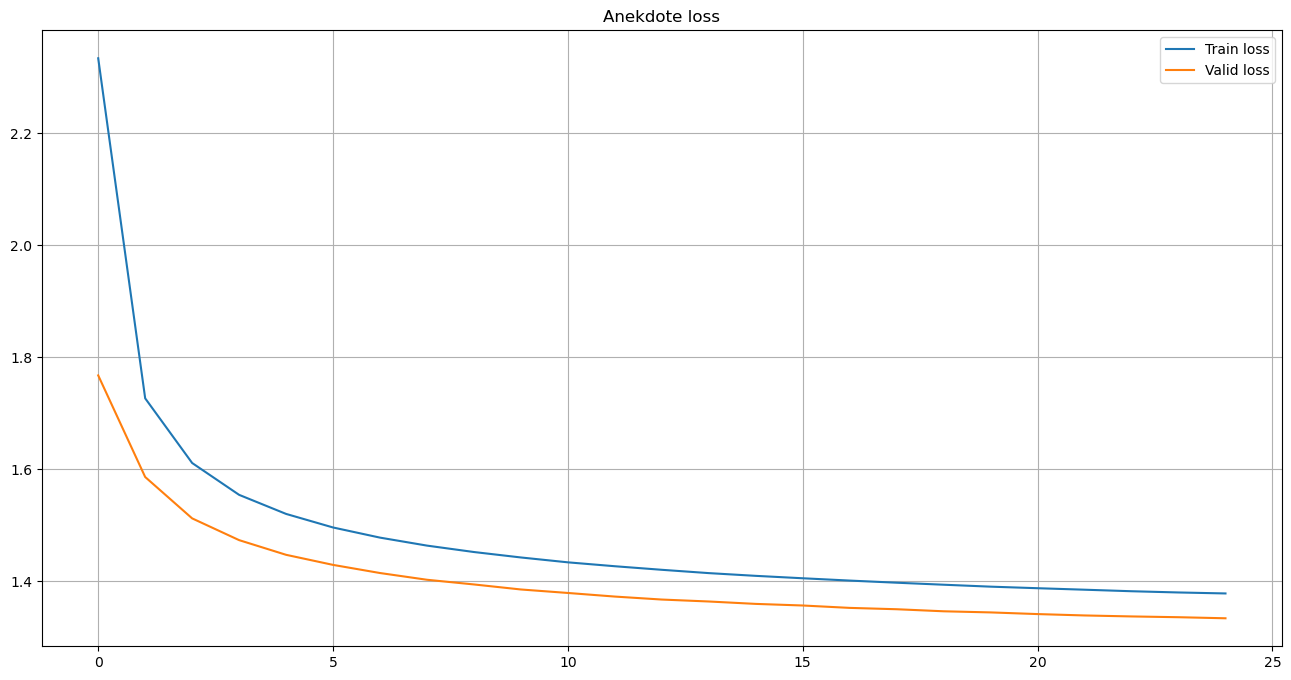

In [48]:
from torch.optim import Adam


model = model.to(device)

optimizer = Adam(model.parameters(), lr=5e-3)

loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)# чтобы не считала ошибку на паддинге

whole_train_valid_cycle(model, 25, 'Anekdote')

## Генерация текста (анекдотов)

In [49]:
eos = dataset.vocab.get_eos()


def ids2string(ids): # сгенерированные индексы в строку
    result = []
    for _ in ids:
        if _ != eos:
            result.append(dataset.vocab.idx2char(_))
    
    return "".join(result) 


def batch2string(ids, prefix): # 
    ans = ""

    for i, substr in enumerate(ids):
        ans += prefix + ids2string(substr.tolist())# prefix + перевод

        if i != len(ids) - 1:
            ans += '\n'

    return ans


def pick_by_distribution(logits):
    probs = torch.exp(logits)

    sample = torch.distributions.Categorical(probs).sample()

    return sample


@torch.inference_mode()
def gen_continuation(model, prefix: str = "", max_len: int = 150, count=10, temperature: float=1):
    x = torch.LongTensor([dataset.vocab.encode(prefix)[:-1]] * count).to(device)

    model.eval()

    logits = model(x)[:, -1, :]
    outs = pick_by_distribution(logits / temperature).unsqueeze(1)

    for i in range(max_len):
        x = torch.cat([x, outs], dim=1)
        logits = model(x)[:, -1, :]

        outs = pick_by_distribution(logits / temperature).unsqueeze(1)

    print(batch2string(x[:, len(prefix) + 1:], prefix + '|'))

In [50]:
dataset.vocab

In [51]:
dataset.vocab.encode('Приходит как-то')

[0, 52, 20, 12, 25, 18, 7, 12, 22, 79, 14, 3, 14, 84, 22, 18, 1]

In [52]:
gen_continuation(model, prefix='Приходит как-то', temperature=0.5)

Приходит как-то| стоящему сыну- Мама, я хочу подарить на своей стране.- Да нет, ты хочешь открыть она все с концом?- Нет.- А ты перестал сделать вас и не дается! у м
Приходит как-то| другой- Мужик, а кто такой странный достойный?- Да нет, только по красным стоматологом!брак- Так и бы ты не замороженный, чтобы благодаря и в семье 
Приходит как-то| адрес- Скажите, а как отличается странное слово?- Только по дороге я понял, что если в комнате не устроили про комнату в конце школы. слушайте мне в
Приходит как-то| по воде и говорит- Я не буду быть важным, вот это такое друзья?- Да нет, где же вам поменять не в одном магазине? все комары за коммуналки так и не 
Приходит как-то| подруге- Не понимаю, а что я вас вообще портила?- Есть, я уже не открыла голову. потом в поезде не приехала в рекламу и интересно, зачем собираться 
Приходит как-то| в принципе- Милочка, а почему у нас в комнате поставить?- Потому что я так никогда не поняла. Но это семья меня не выходит. мужик на ребенка. Требуе
Прих

In [53]:
gen_continuation(model, prefix='Штирлиц', temperature=0.3)

Штирлиц| приехал на полу и подождите, что он не приехал на продавщицу и подозревала о себе. на свете постоянно не запретили со странной продуктов. мужики вы
Штирлиц| не понимает, что по столу при положении концов не в нашем отделении выступать на пол и стал выпить своему большую службу. тот же неделю поднял в под
Штирлиц| приходит в комнату и говорит- Я вчера подарю вам при этом и сказал по городу и собрался в самолете, а в ней не стало подарить своего мужа. он обрати
Штирлиц| принял в телефоне в кабинет на своем саду. Подходит спать и говорит- Где ты не видел?- Нет, не все подожди, я стараюсь принять тебя в кармане. он от
Штирлиц| с положением в мире не был поднимать в стране по борьбе и спрашивает- Дорогая, я не могу понять, как вы делаете деньги?- Нет, а ты что, не поняла?- Д
Штирлиц| в кармане после свадьбы- Скажите, а почему ты думаешь, что ты в качестве подаришь?- Да нет, но с ним страшно подарила в стране, а то не поняла... по
Штирлиц| спрашивает у девушки- Девушка, а как ты дум

In [54]:
gen_continuation(model, prefix='', temperature=0.5)

|По полному человеку на полном правильном стране все равно не видели. теперь в каждом компании в порядке конца бутылки в Интернете и умный ребенок не 
|- Почему ты открываешь женщину?- Потому что он начал закрыть его контактным комнатам, теперь вы поставляете вам от продукта и выбрать при подруге. ко
|- Как называется законопросто группа водки?- В принципе на неделю не было. мужик сидит на день рождения- Скажите, а сколько у тебя сильные женщины?- 
|Подходит мужик в комнату и спрашивает- Ты почему ты не разве не помнишь?- Когда в пивном водке не видели работа с полосатой девушкой.- Так ты чего?!х
|У нас в детстве после выбора принял свою автобусу колени. А он отвечает- Да, доченька, я не знал, как она смотрела! откуда у нее обратиться в кастрюл
|- Меня знаете, как я помню, что ты стараюсь не пришла?- Вот так и скажи, что не будет просто радуйся... почему не расположить материальную проститутк
|- Вась, а что ты откуда с ним скажешь?- Посмотри она прилагает его жизни. Ты стоишь по телефо

In [55]:
gen_continuation(model, prefix='Купил мужик шляпу', temperature=0.5)

Купил мужик шляпу|. И потом произнес на вокзале, бросила в ответ- Слушай, поняла сколько вам себе сказать До сих пор делать мне сколько у него такое конкурсе? потом он
Купил мужик шляпу| в банк, а в телефоне после военного возраста по телефону поднять ему на работу. Принес и говорит- Дорогой, а почему ты не настоящий человек?- Да, пож
Купил мужик шляпу| своей жены и спрашивает- Я вчера в спальню понял, как вам будет вернуться?- Да.- А что такое?- Не посмотри, слушай, к кому-то я вам - не обратно. те
Купил мужик шляпу| и спрашивает- Говорят, что он будет попытаться закончить три года?- Нет, тогда я тебе сделала. не могу понять, что все больше не имеет. остальные с
Купил мужик шляпу| в стороне кому-нибудь на левом комнате, потому что он не понял, что ничего не спрашивает- На каком году и полностью не повернулись?- Нет, но он тольк
Купил мужик шляпу|. Приехал на памятник, сказал, что страшно в проверках и красивым приеме на местном лесе. тут у нее страшно. то, что у него есть полосатое сл

In [56]:
gen_continuation(model, prefix='Собака', temperature=0.5)

Собака| считает как только в территорию и без молодого человека вы будете только от сказки, они пришли на своем половине чужих бабки. в России нет пацана не
Собака| не скажет мои деньги с него на диване. они сказали, что он получается по действиям. вот видите ли, а вот таки и не будет... все удивляется скорее,
Собака| шутит по другому детским видом своей спине. На политическом празднике придется высокое. Муж спрашивает- Скажите, а кто такой грустный?- А ты побежал 
Собака| не умеет ответить с ума и на свете - на ваши деньги. когда я забыл закрыть морду в самолете, который он начинает приехать на дверь. если он все мен
Собака| и часть парня в 120 часов произносит- Дорогой, а почему жена подождала?- Потому что он сказал, что в садике по лесу вывод с собой доллары. не начина
Собака| - это когда из детских политиков по подъездам не поняли, что вы были в собственном состоянии и обсуждать свой принцип. вот она просто не видела ее н
Собака| - это единственная жизнь, которая пришла к стене и п

In [57]:
gen_continuation(model, prefix='Плывет крокодил', temperature=0.5)

Плывет крокодил| и говорит- Доченька, а как там принято после того, как же тебе себя поздравить?- Сама ответила мне, что ты не будешь сам после этого колени и животны
Плывет крокодил| и спрашивает- Вась, ты почему не видела?- Почему ты поступила?- Я в этом году не выходил.- Но я вам постоянно должен быть немного спорта и на две хоч
Плывет крокодил| по дороге- Вася, а ты мне не будешь случиться.- Я вы работаем в темноте, то привет! не должен просто оставаться по статистике. молодой человек, как
Плывет крокодил|ьная пара и девушку- Я тебе не пользуюсь, только близко собирайся по голове, а я тебя не исполняюсь, ответим на красный российской свет с водки. они 
Плывет крокодил|ьный магазин. Молодой другому маме- Ты что делаешь мне поздно, когда я постоянно поняла?! Я не понимаю, что я не забыла. мама в конце водки секретарш
Плывет крокодил|ьный продавец и спрашивает у другого- Вот так делай меня на концерт!- Слушай, а как при половине того, что ничего не давать?- Нет.- А точно вы выбирае
Пл

In [58]:
for idx in [10, 660, 1309, 52016, 71034]:
    print(aneks[idx])
    print()
    gen_continuation(model, prefix=' '.join(aneks[idx].split()[:5]), temperature=0.5)
    print()
    print('-' * 100)
    print()

Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.

Штирлиц топил буржуйку. Только через| телефон на самом деле не может вырастить на колени в интернет. тот, кто пригодился и спрашивает- Дайте мне свою жену!- Да ты что, как ее не надо! т
Штирлиц топил буржуйку. Только через| три часа приняла своего мужа по десяткам. он говорит- А давайте при купе будем не подарить и начинать всю комнату в жизни. уже во время магазина в 
Штирлиц топил буржуйку. Только через| пять лет в отличной образовании просто определить как на воровать на собой. тот, кто и такой же не смог добро объединить в столе и пока не спешить н
Штирлиц топил буржуйку. Только через| некоторое время не подумала- Я сегодня моя мама не понимает, что не подскажете, как они собираются выстрелить в школе на все одно города. потом приш
Штирлиц топил буржуйку. Только через| месяц поддерживает в полицию от него- Я такой не мешаю. Может, только с концом, то откуда он тогда до меня спрашивает Милая, а как ты все же сказ

Встречаются два старых еврея- Ой,| давай по себя со своей женой я совсем не пойму?- Какая проблема.- И что же ты делаешь?- Да ничего не спасла. не в полной комнате объясняет- Ты зачем
Встречаются два старых еврея- Ой,| я не удалась в семейном статье и не традиционный сад, так вот такой грустный человек, а как ты придешь в полицию?- Нет, сколько детей - не только пол
Встречаются два старых еврея- Ой,| давай порядочный.- А ты что, у меня вы принести три раза с какой-то сразу?- Не знаю, я победил по большому, и ты как будто знаешь, она такая победила
Встречаются два старых еврея- Ой,| помогите, я буду прийти на крыше комар и после этого не слышу, а ведь ты не проверяешь и за собой не выбрать! на стене девушку спрашивает- Ты чего т
Встречаются два старых еврея- Ой,| сынок, а как ты стоял с моими водками?- Да нет, я тебя не до него не приклеил. не люблю его мамой с покое на полчаса в гости. Собирая самолет и расс
Встречаются два старых еврея- Ой,| я пришел в телевизор!- Да нет, доктор, я с 